In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
os.environ["MALLOC_TRIM_THRESHOLD_"] = '0'

import numpy as np
import xarray as xr
import xarray.ufuncs as xu
import xrft
import pandas as pd

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

from functionMaths import *

plt.rc("figure", figsize=(12,10))
plt.rc("font", size=14)

from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, protocol = 'tcp', host = '137.129.155.67')
client = Client(cluster)
client

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46143 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:46143/status,
Dashboard: http://137.129.155.67:46143/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: tcp://137.129.155.67:40923,Workers: 1
Dashboard: http://137.129.155.67:46143/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: tcp://137.129.155.67:36429,Total threads: 4
Dashboard: http://137.129.155.67:47563/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
wave_OLR = ['OLR_Kelvin', 'OLR_Rossby']
indir_data = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/FILTERED_ANOMALY/OLR/'
coeff = 1


In [3]:
ds = xr.open_mfdataset(indir_data + '*.nc', chunks = {'time' : 100, 'lat' : 3}, parallel = True)
ds_DT = ds.differentiate('time', datetime_unit = "s")

# Sans symetrie

In [4]:
ds_phase = xr.open_mfdataset('/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/PHASE/TEMP/*OLR_Rossby.nc', 
                             chunks = {'time' : 100, 'lat' : 3})
ds_phase = xr.where(ds_phase['magnitude'] < 1.3, np.nan, ds_phase)
# ds_phase['vect_x'] = np.cos(ds_plot.amplitude) * ds_plot.magnitude
# ds_phase['vect_y'] = np.sin(ds_plot.amplitude) * ds_plot.magnitude
# ds_phase = ds_plot.chunk({'time' : 1, 'lat' : -1})
indir_temp = '/home/durandy/temp/'
ds_phase.sel(phase = 0).to_netcdf(indir_temp + 'phase_0_Rossby.nc')
ds_plot = xr.open_mfdataset(indir_temp + 'phase_0.nc', chunks = {'time' : 1})


distributed.worker - WARNING - Compute Failed
Function:  getter
args:      (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.netCDF4_.NetCDF4ArrayWrapper object at 0x7f525d676980>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None), slice(None, None, None)))))), (slice(31500, 31600, None), slice(0, 3, None), slice(0, 360, None), slice(0, 32, None)))
kwargs:    {}
Exception: "MemoryError((100, 3, 360, 32), dtype('float64'))"



MemoryError: Unable to allocate 26.4 MiB for an array with shape (100, 3, 360, 32) and data type float64

In [5]:
da = ds['OLR_Rossby'] # .sel(time=ds.time.dt.month.isin([4, 5, 6]))
# for j in range(-20,20,2):
_ds_phase = ds_phase.sel(phase = 0, method = 'nearest')
# del _ds_Test['lat']
# _ds_Test = _ds_Test.expand_dims(lat = ds_plot['lat'], axis = 1)
# _ds_Test = _ds_Test
# _ds_2 = xr.where(_ds_Test.isnull() != True,
#                          _ds['OLR_Kelvin'].isel(phase = 0), np.nan)
da_p = da.where(_ds_phase['amplitude'].isnull() != True)
da_p = da_p.mean(dim = ['time']).load()
da_p

<xarray.DataArray 'OLR_Rossby' (lat: 60, lon: 360)>
array([[-3.2789762 , -3.26085336, -3.26883185, ..., -3.38398051,
        -3.32803277, -3.28161759],
       [-3.19941921, -3.1643871 , -3.17551094, ..., -3.35653485,
        -3.26029409, -3.19716783],
       [-2.70197218, -2.6855446 , -2.79950906, ..., -2.76693802,
        -2.69700957, -2.73134514],
       ...,
       [-2.70861902, -2.78151491, -2.83702984, ..., -2.66439565,
        -2.65536472, -2.64241129],
       [-2.97699398, -2.97497722, -2.952285  , ..., -3.07590468,
        -3.04740364, -2.90144009],
       [-3.31606393, -3.29346893, -3.30703196, ..., -3.1924593 ,
        -3.30342457, -3.37492778]])
Coordinates:
  * lat      (lat) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    phase    int64 0

Text(0.5, 1.0, "Moyenne de l'anomalie d'OLR pour Rossby (phase 0) sans latitude de reference")

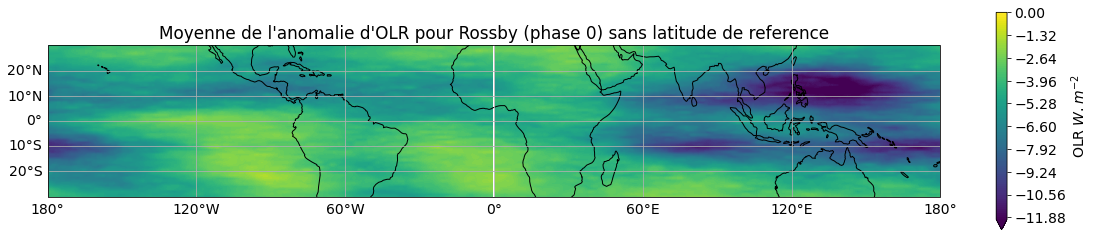

In [12]:
plt.rc("figure", figsize=(16,4))
# plt.rc("figure", figsize=(20,14))
vmin, vmax = -12.0, 0
cmap ='viridis'
    
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'
           }
map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

#####################################################################################
fig, axis = plt.subplots( 1, 1, 
    figsize=(20,4), subplot_kw={'projection': map_proj})

da_p.plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title("Moyenne de l'anomalie d'OLR pour Rossby (phase 0) sans latitude de reference")

In [19]:
da = ds['OLR_Rossby'] # .sel(time=ds.time.dt.month.isin([4, 5, 6]))
# for j in range(-20,20,2):
_ds_phase = ds_phase.sel(phase = 0, lat= 10,method = 'nearest')
del _ds_phase['lat']
_ds_phase = _ds_phase.expand_dims(lat = ds['lat'], axis = 1)

da_p = da.where(_ds_phase['amplitude'].isnull() != True)
da_p = da_p.mean(dim = ['time']).load()
da_p

<xarray.DataArray 'OLR_Rossby' (lat: 60, lon: 360)>
array([[0.26058415, 0.42891557, 0.45129859, ..., 0.12784716, 0.27943099,
        0.27631079],
       [0.28296825, 0.45910582, 0.45496531, ..., 0.08514669, 0.28766835,
        0.29233608],
       [0.41094737, 0.58026754, 0.55009004, ..., 0.24327219, 0.42084245,
        0.4215172 ],
       ...,
       [0.85504013, 0.85405666, 0.85084252, ..., 0.83540845, 0.75408677,
        0.79039773],
       [0.56979381, 0.5884491 , 0.62384345, ..., 0.53852929, 0.48502686,
        0.51979525],
       [0.17945398, 0.20586311, 0.26699634, ..., 0.14566001, 0.109949  ,
        0.15283618]])
Coordinates:
  * lat      (lat) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    phase    int64 0

Text(0.5, 1.0, "Moyenne de l'anomalie d'OLR pour Rossby (phase 0) avec latitude de reference 10 °N")

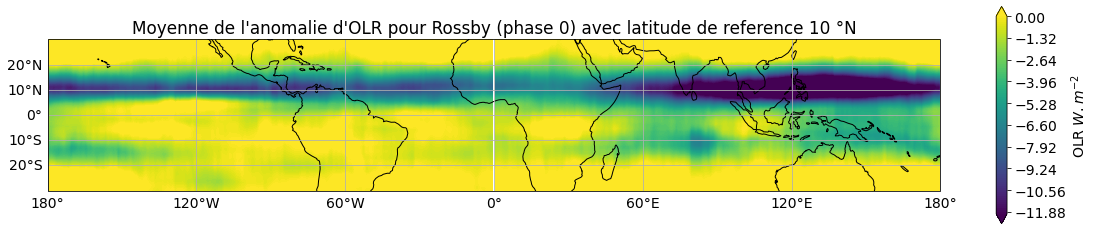

In [20]:
plt.rc("figure", figsize=(16,4))
# plt.rc("figure", figsize=(20,14))
vmin, vmax = -12.0, 0
cmap ='viridis'
    
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'
           }
map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

#####################################################################################
fig, axis = plt.subplots( 1, 1, 
    figsize=(20,4), subplot_kw={'projection': map_proj})

da_p.plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title("Moyenne de l'anomalie d'OLR pour Rossby (phase 0) avec latitude de reference 10 °N")

In [5]:
da = ds_DT['OLR_Rossby'] # .sel(time=ds.time.dt.month.isin([4, 5, 6]))
# for j in range(-20,20,2):
_ds_phase = ds_phase.sel(phase = 8, method = 'nearest')
# del _ds_Test['lat']
# _ds_Test = _ds_Test.expand_dims(lat = ds_plot['lat'], axis = 1)
# _ds_Test = _ds_Test
# _ds_2 = xr.where(_ds_Test.isnull() != True,
#                          _ds['OLR_Kelvin'].isel(phase = 0), np.nan)
da_p = da.where(_ds_phase['amplitude'].isnull() != True)
da_p = da_p.mean(dim = ['time']).load()
da_p

KeyboardInterrupt: 

In [ ]:
plt.rc("figure", figsize=(16,4))
# plt.rc("figure", figsize=(20,14))
vmin, vmax = -5.0, 5.0
cmap ='viridis'
    
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'
           }
map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

#####################################################################################
fig, axis = plt.subplots( 1, 1, 
    figsize=(20,4), subplot_kw={'projection': map_proj})

da_p.plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title("Moyenne de l'anomalie d/dt(OLR) pour Rossby (phase 8) sans latitude de reference")

In [ ]:
da = ds['OLR_Rossby'] # .sel(time=ds.time.dt.month.isin([4, 5, 6]))
# for j in range(-20,20,2):
_ds_phase = ds_phase.sel(phase = 8, lat= 10,method = 'nearest')
del _ds_phase['lat']
_ds_phase = _ds_phase.expand_dims(lat = ds['lat'], axis = 1)

da_p = da.where(_ds_phase['amplitude'].isnull() != True)
da_p = da_p.mean(dim = ['time']).load()
da_p

In [ ]:
plt.rc("figure", figsize=(16,4))
# plt.rc("figure", figsize=(20,14))
vmin, vmax = -5.0, 5.0
cmap ='viridis'
    
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'
           }
map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

#####################################################################################
fig, axis = plt.subplots( 1, 1, 
    figsize=(20,4), subplot_kw={'projection': map_proj})

da_p.plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title("Moyenne de l'anomalie d/dt(OLR) pour Rossby (phase 8) avec latitude de reference 10 °N")

# Avec Symetrie

In [ ]:
ds_phase = xr.open_mfdataset('/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/PHASE/TEMP/*OLR_Rossby_SYM.nc', chunks = {'time':10})
ds_phase = xr.where(ds_phase['magnitude'] < 1.3, np.nan, ds_phase)

In [ ]:
da = ds['OLR_Rossby'] # .sel(time=ds.time.dt.month.isin([4, 5, 6]))
# for j in range(-20,20,2):
_ds_phase = ds_phase.sel(phase = 0, method = 'nearest')
# del _ds_Test['lat']
# _ds_Test = _ds_Test.expand_dims(lat = ds_plot['lat'], axis = 1)
# _ds_Test = _ds_Test
# _ds_2 = xr.where(_ds_Test.isnull() != True,
#                          _ds['OLR_Kelvin'].isel(phase = 0), np.nan)
da_p = da.where(_ds_phase['amplitude'].isnull() != True)
da_p = da_p.mean(dim = ['time']).load()
da_p

In [ ]:
plt.rc("figure", figsize=(16,4))
# plt.rc("figure", figsize=(20,14))
vmin, vmax = -12.0, 0
cmap ='viridis'
    
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'
           }
map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

#####################################################################################
fig, axis = plt.subplots( 1, 1, 
    figsize=(20,4), subplot_kw={'projection': map_proj})

da_p.plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title("Moyenne de l'anomalie d'OLR pour Rossby (phase 0) sans latitude de reference")

In [ ]:
da = ds['OLR_Rossby'] # .sel(time=ds.time.dt.month.isin([4, 5, 6]))
# for j in range(-20,20,2):
_ds_phase = ds_phase.sel(phase = 0, lat= 10,method = 'nearest')
del _ds_phase['lat']
_ds_phase = _ds_phase.expand_dims(lat = ds['lat'], axis = 1)

da_p = da.where(_ds_phase['amplitude'].isnull() != True)
da_p = da_p.mean(dim = ['time']).load()
da_p

In [ ]:
plt.rc("figure", figsize=(16,4))
# plt.rc("figure", figsize=(20,14))
vmin, vmax = -12.0, 0
cmap ='viridis'
    
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'
           }
map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

#####################################################################################
fig, axis = plt.subplots( 1, 1, 
    figsize=(20,4), subplot_kw={'projection': map_proj})

da_p.plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title("Moyenne de l'anomalie d'OLR pour Rossby (phase 0) avec latitude de reference 10 °N")

In [ ]:
da = ds_DT['OLR_Rossby'] # .sel(time=ds.time.dt.month.isin([4, 5, 6]))
# for j in range(-20,20,2):
_ds_phase = ds_phase.sel(phase = 8, method = 'nearest')
# del _ds_Test['lat']
# _ds_Test = _ds_Test.expand_dims(lat = ds_plot['lat'], axis = 1)
# _ds_Test = _ds_Test
# _ds_2 = xr.where(_ds_Test.isnull() != True,
#                          _ds['OLR_Kelvin'].isel(phase = 0), np.nan)
da_p = da.where(_ds_phase['amplitude'].isnull() != True)
da_p = da_p.mean(dim = ['time']).load()
da_p

In [ ]:
plt.rc("figure", figsize=(16,4))
# plt.rc("figure", figsize=(20,14))
vmin, vmax = -5.0, 5.0
cmap ='viridis'
    
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'
           }
map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

#####################################################################################
fig, axis = plt.subplots( 1, 1, 
    figsize=(20,4), subplot_kw={'projection': map_proj})

da_p.plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title("Moyenne de l'anomalie d/dt(OLR) pour Rossby (phase 8) sans latitude de reference 10 °N")